This notebook will go through the process for clustering songs into playlists using the DBSCAN algorithm

In [106]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [107]:
raw_data = pd.read_csv('dataset.csv')
print(raw_data.head())

   danceability  energy  key  loudness  speechiness  acousticness  \
0         0.680   0.729    7    -5.097       0.0418        0.3670   
1         0.584   0.607   11    -6.605       0.0356        0.4260   
2         0.703   0.643    7    -5.544       0.0706        0.1920   
3         0.746   0.450    7    -8.543       0.0872        0.0407   
4         0.561   0.597   11    -6.000       0.0405        0.2860   

   instrumentalness  liveness  valence    tempo  time_signature  \
0               0.0    0.1590    0.830  120.029               4   
1               0.0    0.1010    0.374  117.817               4   
2               0.0    0.1430    0.528  102.059               4   
3               0.0    0.1720    0.336   95.998               4   
4               0.0    0.0979    0.355   76.826               4   

                 song_uri                     name  mode_major  mode_minor  
0  3TMUdD9vE4DoqDYi7VXStt              Fool's Gold           1           0  
1  3TKpJrY9q49Mj1JOsM9zGL   

In [151]:
scaler = StandardScaler()

cols_to_scale = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 
'acousticness','instrumentalness','liveness','valence','tempo','time_signature']

raw_data = raw_data.astype({'key': 'float64', 'time_signature':'float64'}, copy=True)
scaled_data = raw_data.copy()
scaled_data = scaled_data.drop(columns=['song_uri', 'name'])
# scaled_data = scaled_data.drop(columns=['song_uri', 'name', 'loudness', 'liveness', 'time_signature'])
# scaled_data = scaled_data.drop(columns=['song_uri', 'name', 'loudness', 'liveness', 'time_signature', 'instrumentalness', 'speechiness'])

print(scaled_data.head())
algo_data = scaled_data.to_numpy()

   danceability  energy   key  loudness  speechiness  acousticness  \
0         0.680   0.729   7.0    -5.097       0.0418        0.3670   
1         0.584   0.607  11.0    -6.605       0.0356        0.4260   
2         0.703   0.643   7.0    -5.544       0.0706        0.1920   
3         0.746   0.450   7.0    -8.543       0.0872        0.0407   
4         0.561   0.597  11.0    -6.000       0.0405        0.2860   

   instrumentalness  liveness  valence    tempo  time_signature  mode_major  \
0               0.0    0.1590    0.830  120.029             4.0           1   
1               0.0    0.1010    0.374  117.817             4.0           1   
2               0.0    0.1430    0.528  102.059             4.0           1   
3               0.0    0.1720    0.336   95.998             4.0           1   
4               0.0    0.0979    0.355   76.826             4.0           0   

   mode_minor  
0           0  
1           0  
2           0  
3           0  
4           1  


In [117]:
print(scaled_data.shape)

(2156, 6)


So the two parameters for DBSCAN are the Minimum # of Points in a neighborhood, and the Maximum Distance between two points in the same neighborhood.<br>
Since our clusters represent playlists, the smallest number of points we would want in a playlist might be 10, as that would give us a 30 minute playlist.<br>
To find some realistic values for distances, let's do some quick analysis.

In [118]:
min_feature_values = np.min(scaled_data)
max_feature_values = np.max(scaled_data)
distance = max_feature_values - min_feature_values
print('\nMax possible distance: {}'.format(np.linalg.norm(distance.values)))


Max possible distance: 160.918194277869


So, an absolute maximum distance in our transformed feature space is about 162.<br>
As epsilon rises, there will be less noise, as more points will be reachable by others.<br>
It is important to note that as min_samples rises, there will be fewer clusters

For min_samples, we will test values from 3 to 25 in increments of 2.<br>
For eps, we will test values from 1 to 4 in increments of 0.2

In [119]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import make_scorer

results = pd.DataFrame(columns=['eps', 'min_samples', 'sil_score', 'db_score'])

from progressbar import ProgressBar
pbar = ProgressBar()
# np.arange(1,4.2,0.2)
for eps in pbar(np.arange(.1,1.4,0.1)):
    for min_samples in np.arange(3,27,2):
        algo = DBSCAN(eps=eps, min_samples=min_samples).fit(algo_data)
        labels = algo.labels_
        num_labels = len(set(labels))
        num_samples = len(algo_data)
        if num_labels <= 2 or num_labels == num_samples:
            sil_score = -1
            db_score = 10
        else:
            sil_score = silhouette_score(algo_data, labels)
            db_score = davies_bouldin_score(algo_data, labels)
        results = results.append({
            'eps': eps,
            'min_samples': min_samples,
            'sil_score': sil_score,
            'db_score': db_score
        }, ignore_index=True)
        
print(results)

C:\Users\srija\Miniconda3\envs\spotify\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\srija\Miniconda3\envs\spotify\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\srija\Miniconda3\envs\spotify\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\srija\Miniconda3\envs\spotify\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\srija\Miniconda3\envs\spotify\lib\site-packages\sklearn\metrics\cluster\unsuper

     eps  min_samples  sil_score   db_score
0    0.1          3.0  -0.666799   2.960762
1    0.1          5.0  -1.000000  10.000000
2    0.1          7.0  -1.000000  10.000000
3    0.1          9.0  -1.000000  10.000000
4    0.1         11.0  -1.000000  10.000000
..   ...          ...        ...        ...
151  1.3         17.0  -0.591404   2.304617
152  1.3         19.0  -0.601176   2.839547
153  1.3         21.0  -0.605419   2.839360
154  1.3         23.0  -0.607914   2.934330
155  1.3         25.0  -0.536611   1.288558

[156 rows x 4 columns]


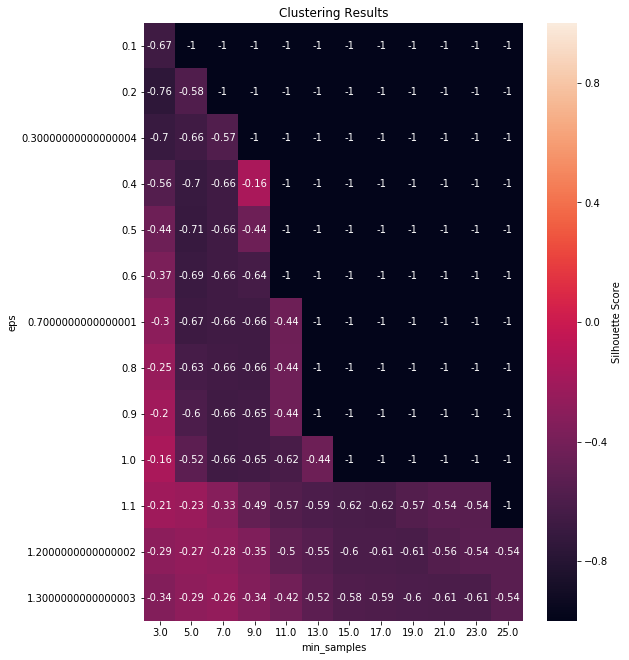

In [120]:
from matplotlib import pyplot as plt
import seaborn as sns

heatmap_results = results.pivot(index='eps', columns='min_samples', values='sil_score')
plt.figure(figsize=(8.5,11))
ax = plt.axes()
sns.heatmap(heatmap_results, cbar_kws={'label': 'Silhouette Score'}, ax=ax, vmin=-1.0, vmax=1.0, annot=True)
# sns.heatmap(heatmap_results, cbar_kws={'label': 'Davies-Bouldin Index'}, ax=ax, vmin=0, annot=True)
ax.set_title('Clustering Results')
plt.show()

In [156]:
chosen_eps = 2.2
chosen_min_samples = 5
# 2.2, 5
# 2, 15
# drop loudness, liveness, and time signature
# 1.6, 5
# 1, 7
# additionally drop instrumentalness and speechiness
# 1.8, 9
# 2.2, 13
algo = DBSCAN(eps=chosen_eps, min_samples=chosen_min_samples).fit(algo_data)
labels = algo.labels_
clusters = set(labels)

total_songs = len(labels)
num_noise = sum(labels==-1)
print('Percent Noise: {:.2f}'.format(100*num_noise/total_songs))
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Number of clusters: {}'.format(n_clusters_))

playlist_clusters = []
for cluster_num, ndx in enumerate(clusters):
    if (ndx == -1):
        print('\nNoise Cluster')
        num_points = sum(labels == ndx)
        print('Number of Points: {}'.format(num_points))
    else:    
        num_points = sum(labels == ndx)
        if (num_points > 10):
            print('\nCluster {}'.format(cluster_num + 1))
            print('Number of Points: {}'.format(num_points))
            cluster = raw_data.iloc[(labels == ndx), :]
            print('Cluster Songs:\n{}'.format(cluster.name))
            playlist_clusters.append(ndx)

Percent Noise: 20.96
Number of clusters: 22

Cluster 1
Number of Points: 1505
Cluster Songs:
0                            Fool's Gold
1                                 Family
2                                For You
3                                Mean It
6                     Heat of the Summer
                      ...               
2151                             Sundara
2152                            Kusanagi
2153                   Echoes (feat. Py)
2154                                Koto
2155    Sun Models (feat. Madelyn Grant)
Name: name, Length: 1505, dtype: object

Cluster 2
Number of Points: 11
Cluster Songs:
5                        Outnumbered
421      Playinwitme (feat. Kehlani)
576                       Showed You
666                             2006
751                  Black & Chinese
787          Reason (& Metro Boomin)
836                            Drama
1109    Seven Million (feat. Future)
1254                    Sunday Candy
1526                        Polaroid

In [157]:
output_data = raw_data.copy()
output_data = output_data[['song_uri', 'name']]
output_data['cluster'] = labels
output_data = output_data[output_data.cluster.isin(playlist_clusters)]
print(output_data.shape)

(1615, 3)


In [158]:
print(output_data.head())

                 song_uri         name  cluster
0  3TMUdD9vE4DoqDYi7VXStt  Fool's Gold        0
1  3TKpJrY9q49Mj1JOsM9zGL       Family        0
2  0CJvDUBeEL1Rmpx7MH28CQ      For You        0
3  3GRSqlALWISqLeNncZMbpX      Mean It        0
5  6UjZ2Yx2g2a52XxiA8ONxZ  Outnumbered        1


In [160]:
output_data.to_csv('clustered_7.csv')

In [171]:
print(raw_data.head())
print(raw_data.sort_values(by='valence', axis=0))

   danceability  energy   key  loudness  speechiness  acousticness  \
0         0.680   0.729   7.0    -5.097       0.0418        0.3670   
1         0.584   0.607  11.0    -6.605       0.0356        0.4260   
2         0.703   0.643   7.0    -5.544       0.0706        0.1920   
3         0.746   0.450   7.0    -8.543       0.0872        0.0407   
4         0.561   0.597  11.0    -6.000       0.0405        0.2860   

   instrumentalness  liveness  valence    tempo  time_signature  \
0               0.0    0.1590    0.830  120.029             4.0   
1               0.0    0.1010    0.374  117.817             4.0   
2               0.0    0.1430    0.528  102.059             4.0   
3               0.0    0.1720    0.336   95.998             4.0   
4               0.0    0.0979    0.355   76.826             4.0   

                 song_uri                     name  mode_major  mode_minor  
0  3TMUdD9vE4DoqDYi7VXStt              Fool's Gold           1           0  
1  3TKpJrY9q49Mj1JOsM9